In [1]:
import sys
sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Base Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt

from scipy.stats import skew, kurtosis

### Import Dal-io Pieces

In [3]:
from dalio.base.memory import LazyRunner, LocalMemory

from dalio.external import (
    YahooDR, 
    PyPlotGraph, 
    PandasInFile,
)

from dalio.translator import (
    YahooStockTranslator,
    StockStreamFileTranslator,
)
    
from dalio.pipe import (
    Pipe,
    ColSelect, 
    Change,
    DateSelect,
    StockReturns, 
    Period, 
    Custom, 
    Rolling,
    CovShrink, 
    PandasLinearModel,
    ExpectedReturns,
    OptimumWeights,
    MakeARCH,
    ValueAtRisk,
    ExpectedShortfall,
    PipeLine
)

from dalio.model import (
    MakeEfficientFrontier, 
    OptimumPortfolio,
)

from dalio.application import (
    Grapher,
    PandasXYGrapher,
    VaRGrapher,
)

from dalio.ops import risk_metrics


Bad key "text.kerning_factor" on line 4 in
/home/renatomz/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Basic Setup

In [4]:
yahoo_in = YahooStockTranslator()(YahooDR())
yahoo = ColSelect(columns="adj_close")(yahoo_in)

In [5]:
forex = StockStreamFileTranslator()(PandasInFile("../tests/sample_forex.xls"))
funds = StockStreamFileTranslator()(PandasInFile("../tests/sample_funds.xls"))

In [6]:
raw_in = Pipe()(forex)

### VaR

In [7]:
time = DateSelect()\
    .set_start("1988-01")\
    .set_end("1997-08")

mem = LazyRunner(LocalMemory, buff=4, update=True)(raw_in)
# mem = raw_in

price = PipeLine(time)(mem)

In [8]:
price.run()

attribute,price
ticker,JPY-USD
date,
1988-01-06,0.007728
1988-01-07,0.007779
1988-01-08,0.007746
1988-01-11,0.007816
1988-01-12,0.007837
...,...
1997-07-28,0.008496
1997-07-29,0.008467


In [9]:
simple_rets = price + Change(strategy="pct_change")

one_tick = "JPY-USD"
ticker = ["DJI", "GSPC" , "IXIC"]

In [10]:
simple_rets.run()

attribute,price
ticker,JPY-USD
date,
1988-01-06,0.000000
1988-01-07,0.006599
1988-01-08,-0.004242
1988-01-11,0.009037
1988-01-12,0.002687
...,...
1997-07-28,-0.007892
1997-07-29,-0.003382


In [11]:
rets_avg = simple_rets + Custom(np.mean)
rets_std = simple_rets + Custom(np.std)

In [12]:
rets_avg.run(ticker=one_tick)

attribute  ticker 
price      JPY-USD    0.000058
dtype: float64

In [13]:
am = MakeARCH()\
    .set_input(simple_rets + Custom(lambda df: df * 100, strategy="pipe"))\
    .set_piece("mean", "ConstantMean")\
    .set_piece("volatility", "RiskMetrics", lam=None)\
    .set_piece("distribution", "Normal")

In [14]:
res = am.run(ticker=one_tick).fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2366.59249889414
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2366.554140714342
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2363.8155625852405
Iteration:      4,   Func. Count:     22,   Neg. LLF: 2359.749666607923
Iteration:      5,   Func. Count:     27,   Neg. LLF: 2358.668636136873
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2358.653024041436
Iteration:      7,   Func. Count:     35,   Neg. LLF: 2358.6505169891134
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2358.6505122616936
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2358.650512261831
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8


In [15]:
res.params

mu     0.010323
lam    0.966188
Name: params, dtype: float64

In [16]:
am2 = am.with_piece("volatility", "GARCH", p=1, q=1)

In [17]:
res2 = am2.run(ticker=one_tick).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2325.0961382797414
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2324.722838009522
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2324.6951566425887
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2322.867598163117
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2321.431361459592
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2321.0304881820684
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2320.8155376923073
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2320.804020075113
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2320.803537345307
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2320.8035230334635
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2320.8035193297237
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2320.803519329331
            Iterations: 11
            Function evaluations: 80
            Gradient evaluati

In [18]:
res2.params

mu          0.000948
omega       0.019266
alpha[1]    0.067011
beta[1]     0.888593
Name: params, dtype: float64

In [19]:
VaR025 = am.pipeline(ValueAtRisk(quantiles=[0.025]))

In [20]:
var = VaR025.run(ticker=one_tick)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2366.59249889414
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2366.554140714342
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2363.8155625852405
Iteration:      4,   Func. Count:     22,   Neg. LLF: 2359.749666607923
Iteration:      5,   Func. Count:     27,   Neg. LLF: 2358.668636136873
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2358.653024041436
Iteration:      7,   Func. Count:     35,   Neg. LLF: 2358.6505169891134
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2358.6505122616936
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2358.650512261831
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8


In [21]:
var

,returns,2.5%,max_exedence
date,,,
1988-01-06,0.000000,1.543328,1.0
1988-01-07,0.659938,1.534678,1.0
1988-01-08,-0.424219,1.516387,1.0
1988-01-11,0.903692,1.524505,1.0
1988-01-12,0.268680,1.501205,1.0
...,...,...,...
1997-07-28,-0.789156,1.512545,1.0
1997-07-29,-0.338192,1.491838,1.0
1997-07-30,-0.130679,1.467098,1.0


Iteration:      1,   Func. Count:      4,   Neg. LLF: 2366.59249889414
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2366.554140714342
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2363.8155625852405
Iteration:      4,   Func. Count:     22,   Neg. LLF: 2359.749666607923
Iteration:      5,   Func. Count:     27,   Neg. LLF: 2358.668636136873
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2358.653024041436
Iteration:      7,   Func. Count:     35,   Neg. LLF: 2358.6505169891134
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2358.6505122616936
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2358.650512261831
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8


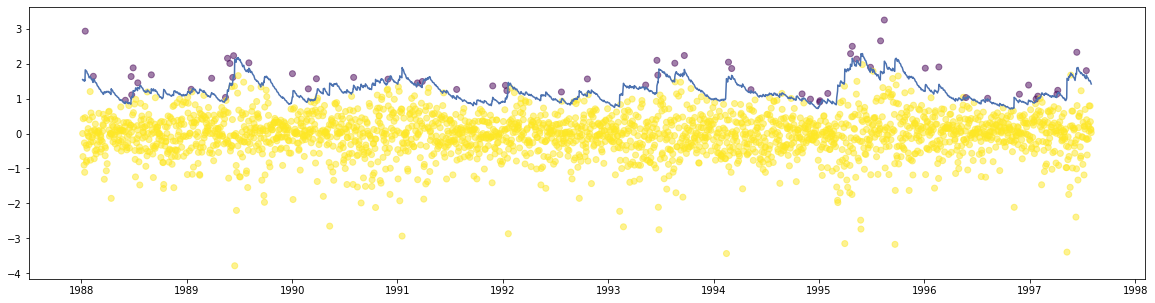

In [22]:
var_grapher = VaRGrapher()\
    .set_input("data_in", VaR025)\
    .set_output("data_out", PyPlotGraph(figsize=(20, 5)))

fig = var_grapher.run(ticker=one_tick)

In [23]:
ES025 = am.pipeline(ExpectedShortfall(quantiles=[0.025]))

In [24]:
ES025.run(ticker=one_tick)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2366.59249889414
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2366.554140714342
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2363.8155625852405
Iteration:      4,   Func. Count:     22,   Neg. LLF: 2359.749666607923
Iteration:      5,   Func. Count:     27,   Neg. LLF: 2358.668636136873
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2358.653024041436
Iteration:      7,   Func. Count:     35,   Neg. LLF: 2358.6505169891134
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2358.6505122616936
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2358.650512261831
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8


,expected_shortfall
0.025,-1.616615


### Switch input

In [25]:
raw_in.set_input(funds)

# clear memory for new input
mem.clear()

In [26]:
time.set_start("2011-01")
time.set_end("2017-12")

In [27]:
price.run()

attribute         price                           
ticker             GSPC         IXIC           DJI
date                                              
2011-01-03  1271.869995  2691.520020  11670.750000
2011-01-04  1270.199951  2681.250000  11691.179688
2011-01-05  1276.560059  2702.199951  11722.889648
2011-01-06  1273.849976  2709.889893  11697.309570
2011-01-07  1271.500000  2703.169922  11674.759766
...                 ...          ...           ...
2017-11-27  2601.419922  6878.520020  23580.779297
2017-11-28  2627.040039  6912.359863  23836.710938
2017-11-29  2626.070068  6824.390137  23940.679688
2017-11-30  2647.580078  6873.970215  24272.349609
2017-12-01  2642.219971  6847.589844  24231.589844

[1742 rows x 3 columns]

In [28]:
S = CovShrink()(price)\
    .set_piece("shrinkage", "ledoit_wolf")

mu = ExpectedReturns()(price)\
    .set_piece("return_model", "mean_historical_return")

In [29]:
annual_rets = price + \
    Period("Y", agg_func=lambda x: x[-1]) + \
    Change(strategy="pct_change", rm_first=True)

ann_agg = annual_rets + Custom(np.mean)

In [30]:
cov_rets = annual_rets + Custom(lambda x: x.cov(), strategy="pipe")

In [31]:
ef = MakeEfficientFrontier(weight_bounds=(0, 1))\
    .set_input("sample_covariance", cov_rets)\
    .set_input("expected_returns", ann_agg)

opt_weights = OptimumWeights()(ef)\
    .set_piece("strategy", "max_sharpe", risk_free_rate=0.0)

In [32]:
cov_rets.run(ticker=ticker)

attribute            price                    
ticker                GSPC      IXIC       DJI
attribute ticker                              
price     GSPC    0.010988  0.013397  0.010554
          IXIC    0.013397  0.017700  0.012930
          DJI     0.010554  0.012930  0.011711

In [33]:
opt_weights.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


{'GSPC': 0.0, 'IXIC': 1.0, 'DJI': 0.0}

In [34]:
opt_port = OptimumPortfolio()\
    .set_input("data_in", price)\
    .set_input("weights_in", opt_weights)

In [35]:
opt_port.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


attribute,price
ticker,portfolio
date,
2011-01-03,2691.520020
2011-01-04,2681.250000
2011-01-05,2702.199951
2011-01-06,2709.889893
2011-01-07,2703.169922
...,...
2017-11-27,6878.520020
2017-11-28,6912.359863


In [36]:
opt_rets = PipeLine(StockReturns())(opt_port)
opt_avg = rets_avg.with_input(opt_rets)
opt_std = rets_std.with_input(opt_rets)

In [37]:
# set input of ARCH Model, as that is in turn the value at risk input
VaR025.set_input(opt_rets) # same as am.set_input(opt_port_scaled)

In [38]:
VaR025.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


Iteration:      1,   Func. Count:      4,   Neg. LLF: 2361.7130642376897
Iteration:      2,   Func. Count:     11,   Neg. LLF: 2361.688311997107
Iteration:      3,   Func. Count:     16,   Neg. LLF: 2360.3476047037234
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2359.7863388801416
Iteration:      5,   Func. Count:     25,   Neg. LLF: 2359.7494468611685
Iteration:      6,   Func. Count:     29,   Neg. LLF: 2359.712123018102
Iteration:      7,   Func. Count:     33,   Neg. LLF: 2359.7034498210687
Iteration:      8,   Func. Count:     37,   Neg. LLF: 2359.7034389024684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2359.703438902295
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8


,returns,2.5%,max_exedence
date,,,
2011-01-03,0.000000,1.445951,1.000
2011-01-04,-0.381570,1.422370,1.000
2011-01-05,0.781350,1.418967,1.000
2011-01-06,0.284581,1.387179,1.000
2011-01-07,-0.247979,1.359145,1.000
...,...,...,...
2017-11-27,-0.154448,1.032024,1.000
2017-11-28,0.491964,1.021613,1.000
2017-11-29,-1.272644,1.137068,0.025


In [39]:
ES025.set_input(opt_rets)

In [40]:
ES025.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


Iteration:      1,   Func. Count:      4,   Neg. LLF: 2361.7130642376897
Iteration:      2,   Func. Count:     11,   Neg. LLF: 2361.688311997107
Iteration:      3,   Func. Count:     16,   Neg. LLF: 2360.3476047037234
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2359.7863388801416
Iteration:      5,   Func. Count:     25,   Neg. LLF: 2359.7494468611685
Iteration:      6,   Func. Count:     29,   Neg. LLF: 2359.712123018102
Iteration:      7,   Func. Count:     33,   Neg. LLF: 2359.7034498210687
Iteration:      8,   Func. Count:     37,   Neg. LLF: 2359.7034389024684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2359.703438902295
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8


,expected_shortfall
0.025,-2.401217


### Back Testing

In [41]:
test_dates = DateSelect()\
    .set_start("2018-01")\
    .set_end("2019-12")

bt_price = PipeLine(test_dates)(mem)

bt_port = opt_port\
    .with_input("data_in", bt_price)

bt_rets = opt_rets.with_input(bt_port)

VaR025.set_input(bt_rets)

In [42]:
bt_price.run()

attribute         price                           
ticker             GSPC         IXIC           DJI
date                                              
2018-01-02  2695.810059  7006.899902  24824.009766
2018-01-03  2713.060059  7065.529785  24922.679688
2018-01-04  2723.989990  7077.910156  25075.130859
2018-01-05  2743.149902  7136.560059  25295.869141
2018-01-08  2747.709961  7157.390137  25283.000000
...                 ...          ...           ...
2019-11-22  3110.290039  8519.879883  27875.619141
2019-11-25  3133.639893  8632.490234  28066.470703
2019-11-26  3140.520020  8647.929688  28121.679688
2019-11-27  3153.629883  8705.179688  28164.000000
2019-11-29  3140.979980  8665.469727  28051.410156

[482 rows x 3 columns]

In [43]:
var = VaR025.run(ticker=ticker)
var

Iteration:      1,   Func. Count:      4,   Neg. LLF: 736.2313924538471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 735.0414695306877
Iteration:      3,   Func. Count:     16,   Neg. LLF: 725.2560434260074
Iteration:      4,   Func. Count:     21,   Neg. LLF: 725.0377523972807
Iteration:      5,   Func. Count:     25,   Neg. LLF: 725.0050997938376
Iteration:      6,   Func. Count:     29,   Neg. LLF: 725.004579879025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 725.0045798787268
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6


/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


,returns,2.5%,max_exedence
date,,,
2018-01-02,0.000000,1.707401,1.0
2018-01-03,0.836745,1.638938,1.0
2018-01-04,0.175222,1.498222,1.0
2018-01-05,0.828633,1.453560,1.0
2018-01-08,0.291878,1.331173,1.0
...,...,...,...
2019-11-22,0.160705,0.615680,1.0
2019-11-25,1.321736,0.986013,1.0
2019-11-26,0.178853,0.896747,1.0


/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


Iteration:      1,   Func. Count:      4,   Neg. LLF: 736.2313924538471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 735.0414695306877
Iteration:      3,   Func. Count:     16,   Neg. LLF: 725.2560434260074
Iteration:      4,   Func. Count:     21,   Neg. LLF: 725.0377523972807
Iteration:      5,   Func. Count:     25,   Neg. LLF: 725.0050997938376
Iteration:      6,   Func. Count:     29,   Neg. LLF: 725.004579879025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 725.0045798787268
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6


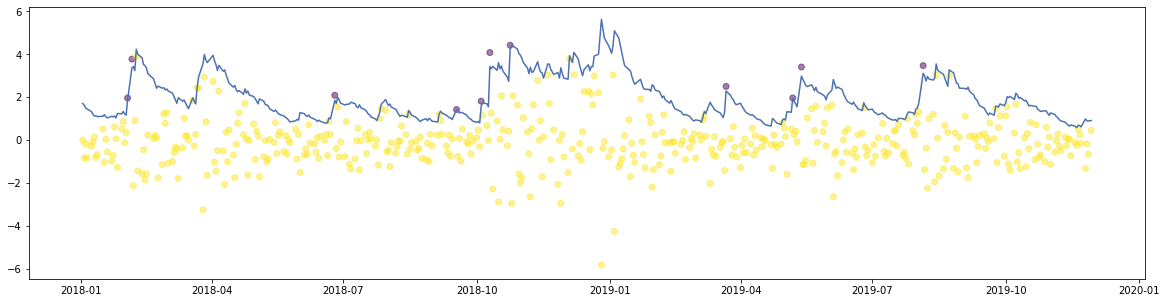

In [44]:
fig = var_grapher.reset_out().run(ticker=ticker)

In [45]:
fig.savefig("var.png")

In [46]:
np.sum(var["max_exedence"] <= 0.025)

11

### RiskMetrics

In [47]:
daily_var = opt_rets + Custom(risk_metrics, 0.94)

In [48]:
daily_var.run(ticker=ticker)

/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


attribute,price
ticker,portfolio
date,
2011-01-03,0.000000
2011-01-04,0.145595
2011-01-05,0.145595
2011-01-06,0.173490
2011-01-07,0.167940
...,...
2017-11-27,0.337661
2017-11-28,0.318833


In [49]:
VaR01 = am.pipeline(
    ValueAtRisk(quantiles=[0.01])
)(bt_rets)

In [50]:
var = VaR01.run(ticker=ticker)
var

Iteration:      1,   Func. Count:      4,   Neg. LLF: 736.2313924538471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 735.0414695306877
Iteration:      3,   Func. Count:     16,   Neg. LLF: 725.2560434260074
Iteration:      4,   Func. Count:     21,   Neg. LLF: 725.0377523972807
Iteration:      5,   Func. Count:     25,   Neg. LLF: 725.0050997938376
Iteration:      6,   Func. Count:     29,   Neg. LLF: 725.004579879025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 725.0045798787268
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6


/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


,returns,1.0%,max_exedence
date,,,
2018-01-02,0.000000,2.054937,1
2018-01-03,0.836745,1.973676,1
2018-01-04,0.175222,1.806655,1
2018-01-05,0.828633,1.753645,1
2018-01-08,0.291878,1.608379,1
...,...,...,...
2019-11-22,0.160705,0.759136,1
2019-11-25,1.321736,1.198697,1
2019-11-26,0.178853,1.092744,1


/home/renatomz/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


Iteration:      1,   Func. Count:      4,   Neg. LLF: 736.2313924538471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 735.0414695306877
Iteration:      3,   Func. Count:     16,   Neg. LLF: 725.2560434260074
Iteration:      4,   Func. Count:     21,   Neg. LLF: 725.0377523972807
Iteration:      5,   Func. Count:     25,   Neg. LLF: 725.0050997938376
Iteration:      6,   Func. Count:     29,   Neg. LLF: 725.004579879025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 725.0045798787268
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6


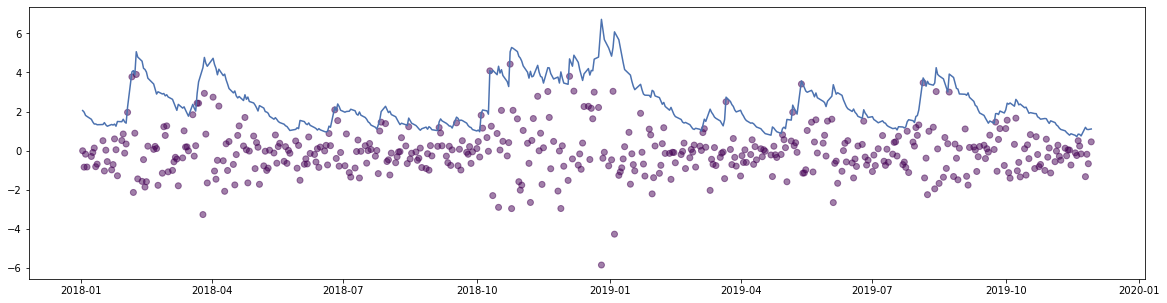

In [51]:
var_grapher.set_input("data_in", VaR01)

fig = var_grapher.reset_out().run(ticker=ticker)

In [52]:
np.sum(var["max_exedence"] <= 0.01)

0

In [53]:
np.sum(var["returns"] <= -var["1.0%"])

0